# Prepare the Environment

In [1]:
!git clone https://github.com/mhamilton723/STEGO.git

Cloning into 'STEGO'...
remote: Enumerating objects: 204, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 204 (delta 27), reused 21 (delta 21), pack-reused 166
Receiving objects: 100% (204/204), 9.23 MiB | 23.11 MiB/s, done.
Resolving deltas: 100% (104/104), done.


In [2]:
!pip intsall gdown
!pip install wget
!pip install torchmetrics
!pip install hydra-core
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git
!pip install omegaconf
!pip install pytorch-lightning
!pip install rembg

ERROR: unknown command "intsall" - maybe you meant "install"
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=3a8d6e87ef864643d7da11a794a4c715868a7a8216a0075ebc070104c8d42903
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 529 kB 12.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 151 kB 12.9 MB/s 
     |████████████████████████████████| 117 kB 22.7 MB/s 
     |████████████████████████████████| 79 kB 9.2 MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144575 sha256=733cdadd2699fb0da5c1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-ecf_msah
  Running command git clone -q https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-ecf_msah
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pydensecrf: filename=pydensecrf-1.0rc2-cp37-cp37m-linux_x86_64.whl size=2781650 sha256=53b6d2d030e703334b8d4aa46479ecfc23e53e47fecba494aa03b869ca10c568
  Stored in directory: /tmp/pip-ephem-wheel-cache-lpfhvwb8/wheels/c1/7e/80/99adc0b2f215180486e24dd9c700028343ba5f566514a0ef05
Successfully built pydensecrf
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 708 kB 15.2 MB/s 

In [3]:
!gdown --id 1XoP3MRse9Lcz2LrfLrjXMms-Ndkvu803

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1XoP3MRse9Lcz2LrfLrjXMms-Ndkvu803
To: /content/input_data_accessories.zip
100% 912k/912k [00:00<00:00, 141MB/s]


In [4]:
import os
import zipfile


zip_ref = zipfile.ZipFile("./input_data_accessories.zip", 'r')
zip_ref.extractall("STEGO/src/")
zip_ref.close()

os.remove("input_data_accessories.zip")

In [5]:
import shutil


os.chdir("STEGO")
shutil.rmtree("results")
os.remove("LICENSE")
os.remove("README.md")
os.remove("environment.yml")

In [6]:
os.chdir("src")
shutil.rmtree("configs")
shutil.rmtree("picie")
os.remove("STEGO_Colab_Demo.ipynb")
os.remove("__init__.py")
os.remove("crop_datasets.py")
os.remove("demo_segmentation.py")
os.remove("download_datasets.py")
os.remove("download_models.py")
os.remove("eval_segmentation.py")
os.remove("plot_dino_correspondence.py")
os.remove("plot_potsdam.py")
os.remove("plot_pr_curves.py")
os.remove("precompute_knns.py")
os.remove("train_crf.py")

# Import Libraries

In [1]:
import os
from os.path import join
import wget
import numpy as np
from PIL import Image
from rembg import remove
import torch
import torch.nn.functional as F
from torchvision.transforms.functional import to_tensor
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

%matplotlib inline

# Download Pretrained Model



In [2]:
os.chdir("STEGO/src")
saved_models_dir = join("..", "saved_models")
os.makedirs(saved_models_dir, exist_ok=True)

In [3]:
saved_model_url_root = "https://marhamilresearch4.blob.core.windows.net/stego-public/saved_models/"
saved_model_name = "cocostuff27_vit_base_5.ckpt"
if not os.path.exists(join(saved_models_dir, saved_model_name)):
  wget.download(saved_model_url_root + saved_model_name, join(saved_models_dir, saved_model_name))

# Load pretrained STEGO

In [4]:
from train_segmentation import LitUnsupervisedSegmenter


model = LitUnsupervisedSegmenter.load_from_checkpoint(join(saved_models_dir, saved_model_name)).cuda()

/content/STEGO/src/train_segmentation.py:386: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path="configs", config_name="train_config.yml")


Since no pretrained weights have been provided, we load the reference pretrained DINO weights.


Downloading: "https://dl.fbaipublicfiles.com/dino/dino_vitbase8_pretrain/dino_vitbase8_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dino_vitbase8_pretrain.pth


  0%|          | 0.00/327M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (UnsupervisedMetrics). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_full_state_property`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


# Remove Background

In [5]:
data_dir = 'input_data_accessories'
face_fnames = os.listdir(data_dir)
print(len(face_fnames))

37


In [6]:
for fname in face_fnames:
  if fname == 'Ricardo9m.jpg':
    continue
  
  img_path = join(data_dir, fname)
  input = Image.open(img_path)
  output = remove(input).convert('RGB')
  output.save(img_path.split(".")[0] + '.jpg')
  
  if img_path.split(".")[1] != 'jpg':
    os.remove(img_path)

Downloading...
From: https://drive.google.com/uc?id=1tCU5MM1LhRgGou5OpmpjBQbSrYIUoYab
To: /root/.u2net/u2net.onnx
100%|██████████| 176M/176M [00:01<00:00, 88.5MB/s]


In [7]:
face_fnames = os.listdir(data_dir)
print(len(face_fnames))

37


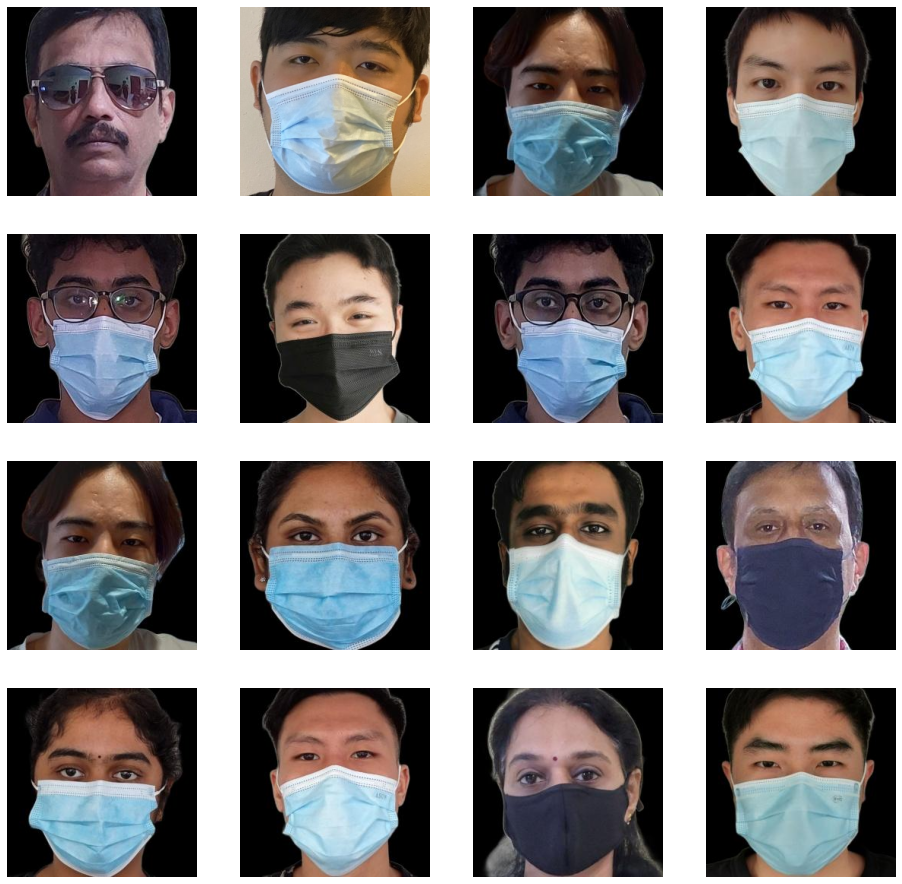

In [8]:
# Parameters for the graph; output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index += 16

next_face_pix = [join(data_dir, fname) for fname in face_fnames[pic_index-16:pic_index]]

for i, img_path in enumerate(next_face_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i+1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

# Testing

## Load Image

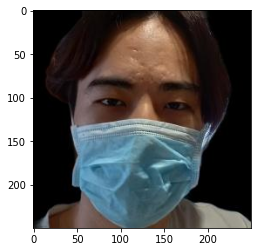

In [11]:
from PIL import Image
from torchvision.transforms.functional import to_tensor
from utils import get_transform


img = Image.open(join(data_dir, face_fnames[2]))
plt.imshow(img)
transform = get_transform(448, False, "center")
img = transform(img).unsqueeze(0).cuda()

## Query model and pass result through CRF

In [12]:
import torch
import torch.nn.functional as F
from crf import dense_crf


with torch.no_grad():
  code1 = model(img)
  code2 = model(img.flip(dims=[3]))
  code  = (code1 + code2.flip(dims=[3])) / 2
  code = F.interpolate(code, img.shape[-2:], mode='bilinear', align_corners=False)
  linear_probs = torch.log_softmax(model.linear_probe(code), dim=1).cpu()
  cluster_probs = model.cluster_probe(code, 2, log_probs=True).cpu()

  single_img = img[0].cpu()
  linear_pred = dense_crf(single_img, linear_probs[0]).argmax(0)
  cluster_pred = dense_crf(single_img, cluster_probs[0]).argmax(0)

## Visualize Segmentation Result

Note that cluster predictions will not be matched with ground truth classes in this example. For hungarian matching please use: `eval_segmentation.py`

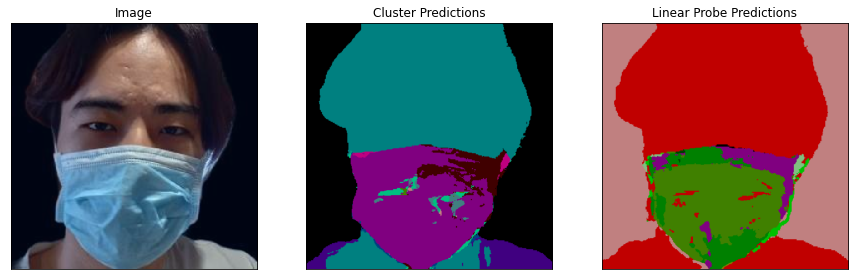

In [13]:
import matplotlib.pyplot as plt
from utils import unnorm, remove_axes


fig, ax = plt.subplots(1,3, figsize=(5*3,5))
ax[0].imshow(unnorm(img)[0].permute(1,2,0).cpu())
ax[0].set_title("Image")
ax[1].imshow(model.label_cmap[cluster_pred])
ax[1].set_title("Cluster Predictions")
ax[2].imshow(model.label_cmap[linear_pred])
ax[2].set_title("Linear Probe Predictions")
remove_axes(ax)

## Skin Segmentaion

In [14]:
img_np = model.label_cmap[cluster_pred]

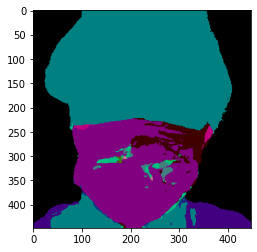

In [15]:
plt.imshow(img_np)

In [16]:
img_np[:, 200, :]

array([[  0, 128, 128],
       [  0, 128, 128],
       [  0, 128, 128],
       ...,
       [128,   0, 128],
       [128,   0, 128],
       [128,   0, 128]])

In [17]:
def my_func(a):
  return 1 if a[0] and a[1] and a[2] else 0

In [18]:
import numpy as np


vals = np.array([0, 128, 128])
mask = np.apply_along_axis(my_func, -1, img_np == vals)
mask = np.expand_dims(mask, axis=-1)
ori_img = unnorm(img)[0].permute(1,2,0).cpu().detach().numpy()
skin = ori_img * mask

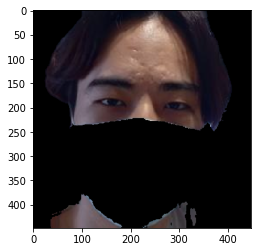

In [19]:
plt.imshow(skin)

In [23]:
output = Image.fromarray((skin * 255).astype(np.uint8))
output.save('test.jpg')

# Skin Segmentation

In [9]:
from utils import get_transform, unnorm
from crf import dense_crf


def and_op(a):
  return 1 if a[0] and a[1] and a[2] else 0

for fname in face_fnames:
  img_path = join(data_dir, fname)
  img = Image.open(img_path)
  transform = get_transform(448, False, "center")
  img = transform(img).unsqueeze(0).cuda()

  with torch.no_grad():
    code1 = model(img)
    code2 = model(img.flip(dims=[3]))
    code = (code1 + code2.flip(dims=[3])) / 2
    code = F.interpolate(code, img.shape[-2:], mode='bilinear', align_corners=False)
    #linear_probs = torch.log_softmax(model.linear_probe(code), dim=1).cpu()
    cluster_probs = model.cluster_probe(code, 2, log_probs=True).cpu()

    single_img = img[0].cpu()
    #linear_pred = dense_crf(single_img, linear_probs[0]).argmax(0)
    cluster_pred = dense_crf(single_img, cluster_probs[0]).argmax(0)

  img_np = model.label_cmap[cluster_pred]

  vals = np.array([0, 128, 128])
  skin_filter = np.apply_along_axis(and_op, -1, img_np == vals)
  skin_filter = np.expand_dims(skin_filter, axis=-1)
  ori_img = unnorm(img)[0].permute(1,2,0).cpu().detach().numpy()
  skin = ori_img * skin_filter

  output = Image.fromarray((skin * 255).astype(np.uint8))
  output.save(img_path)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


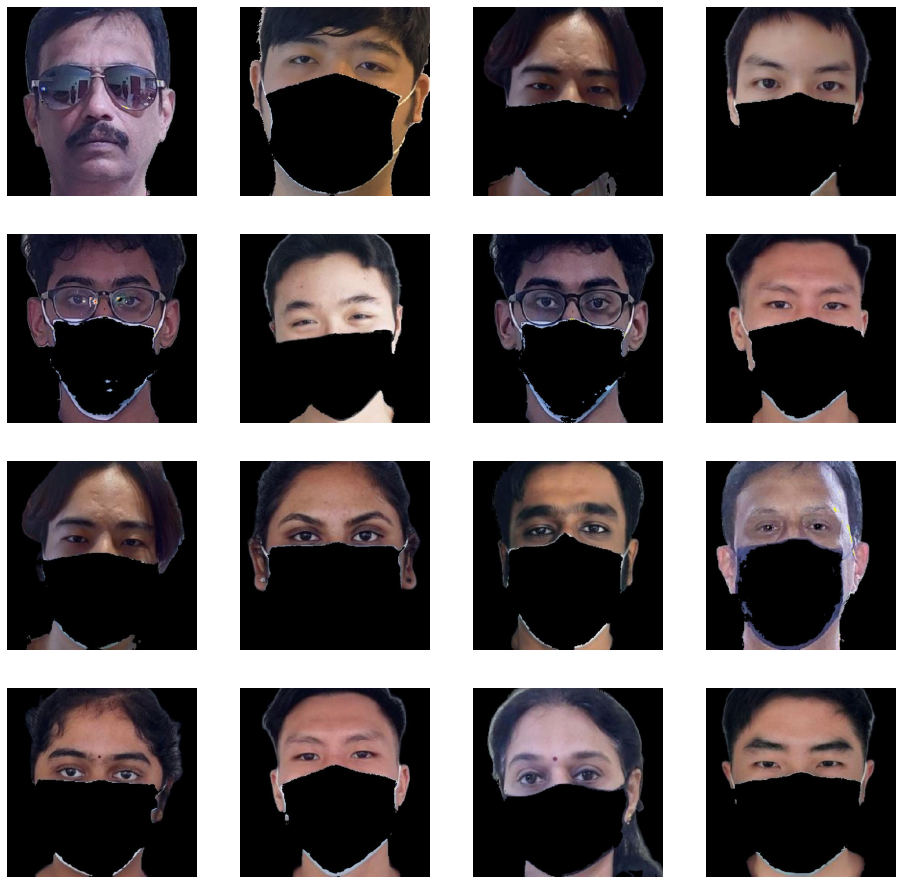

In [10]:
# Parameters for the graph; output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index += 16

next_face_pix = [join(data_dir, fname) for fname in face_fnames[pic_index-16:pic_index]]

for i, img_path in enumerate(next_face_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i+1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()